In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import statsmodels.api as sm
import seaborn as sns
import re
from jupyterthemes import jtplot
from datetime import timedelta, datetime
import calendar
import plotly.express as px
jtplot.style()

# (Preparation) read in fullsample.csv, format

convert BEGIN and END to datetime

split exit code into EXITCODE and SIGNAL

create IN_ARRAY to identify which jobs are in arrays and ARRAYID to identify those arrays explicitly

create TIMEOUT to identify whether USEDTIME exceeded REQTIME

clean REQMEM and USEDMEM, make int-type

create REQMEMxNODES and REQMEMxCPUS columns--if they should actually exist (confirm with team)

In [2]:
slurm_jobs = pd.read_csv('../data/fullsample-corrected.csv')

### convert BEGIN AND END to datetime

In [3]:
dt_converts = ['BEGIN', 'END']

for col in dt_converts:
        slurm_jobs[col] = pd.to_datetime(slurm_jobs[col], errors = 'coerce')

### convert REQTIME AND USEDTIME to timedelta

In [4]:
dt_converts = ['REQTIME', 'USEDTIME']

for col in dt_converts:
        slurm_jobs[col] = pd.to_timedelta(slurm_jobs[col].str.replace('-', ' days '))

### create TIMEOUT to identify whether USEDTIME exceeded REQTIME

In [5]:
slurm_jobs['TIMEOUT'] = slurm_jobs['USEDTIME'] > slurm_jobs['REQTIME']

### split exit code into EXITCODE and SIGNAL

In [6]:
slurm_jobs[['EXITCODE', 'SIGNAL']] = slurm_jobs['EXITCODE'].str.split(':', expand = True)

### create IN_ARRAY to identify which jobs are in arrays and ARRAYID to identify those arrays explicitly

In [7]:
slurm_jobs['IN_ARRAY'] = slurm_jobs['JOBID'].str.contains('_')
slurm_jobs['ARRAYID'] = slurm_jobs['JOBID'].str.extract(r'(.+)_')

### sort values and reset index

In [8]:
slurm_jobs = slurm_jobs.sort_values('END').reset_index(drop = True)

### rolling window of jobs ended per hour (not just the completed ones)

In [9]:
slurm_jobs = slurm_jobs.dropna(subset = ['END'])

In [10]:
slurm_jobs['ROLL1HR'] = (slurm_jobs
                           .rolling('1h', on = 'END')
                            ['JOBID']
                            .count()
                        )

In [13]:
slurm_jobs.to_csv('../data/slurm_jobs.csv', index = False)

# Problem 1

(1A) Calculate some descriptive statistics for how many jobs per hour are being completed. What does the completions per hour look like over the time span of the dataset? 

(1B) Are there weekly trends, and has it been increasing over the last year?

## (1A) What does the completions per hour look like over the time span of the dataset? 

### overall completions per hour for slurm_jobs: 828.6 completions per hour

In [15]:
# define function to calculate total hours of a timedelta
def td_hours(timedelta):
    hours = timedelta.days*24 + timedelta.seconds/3600
    return hours

In [16]:
# overall completions per hour for slurm_jobs
completions = slurm_jobs['END'].count()
time_diff = (slurm_jobs['END'].max() - slurm_jobs['END'].min())
jobs_per_hour = completions/td_hours(time_diff)
print(round(jobs_per_hour, 1), 'completions per hour')

828.6 completions per hour


## (1B) Are there weekly trends, and has it been increasing over the last year?

bar plot of completions per hour by week, colored by months

regression line of completions per hour by week vs week

statsmodel analysis of that regression line

table output of jobs completed per hour by day, summarized by day of the week

bar plot of jobs completed per hour by day, summarized by day of the week

In [17]:
ended_per_hour_by_week = (slurm_jobs.groupby(
                                    pd.Grouper(key = 'END', freq = 'W')) # Group by week
                                    ['JOBID'] # Counting job ids
                                    .count()/168 # divide count by 168 hours in a week
                         )

In [18]:
# display with renamed columns
ended_per_hour_by_week = (ended_per_hour_by_week.reset_index()
                                              .rename(columns = {'END': 'WEEKOF', 
                                                                 'JOBID': 'ENDEDPERHOUR'}
                                                     )
                        )

### Answer: August and September 2021 seem to have higher completions per hour than the rest of the months. 

(We may be able to include October 2020 here, too, which makes me wonder whether the start of the school year has the highest demand.)

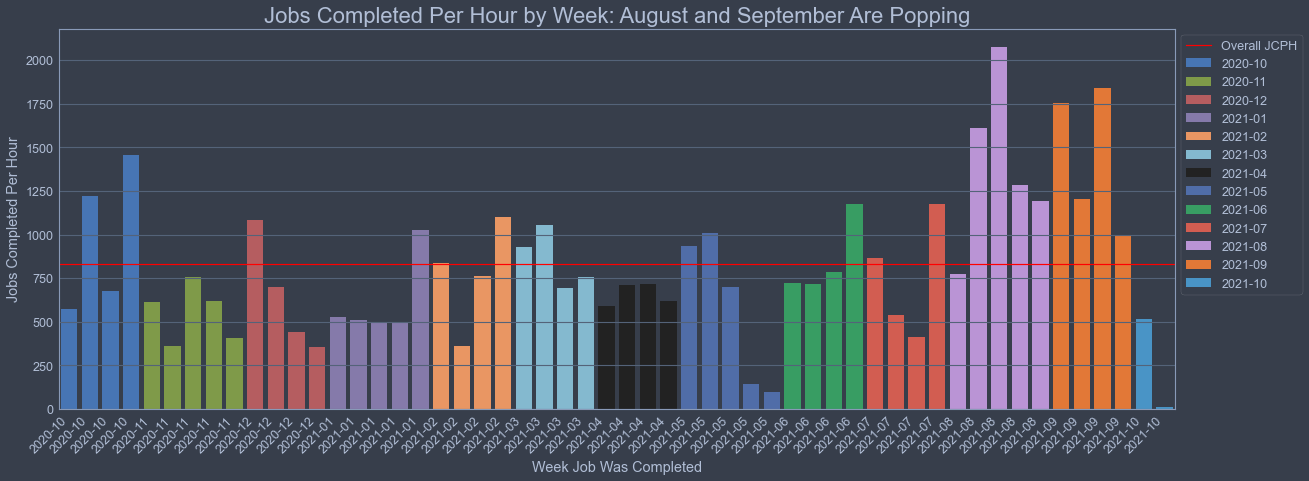

In [38]:
# Plot completions per hour by week, colored by month
fig, ax = plt.subplots(figsize=(20,7))

x_dates = ended_per_hour_by_week['WEEKOF'].dt.strftime('%Y-%m')

sns.barplot(x = 'WEEKOF',
            y = 'ENDEDPERHOUR',
            data = ended_per_hour_by_week,
            ax = ax,
            hue = x_dates,
            dodge = False
           )


ax.set_xticklabels(labels=x_dates, rotation=45, ha='right')
ax.get_legend().remove()
ax.axhline(jobs_per_hour, color = 'red', label = 'Overall JCPH')
ax.set(xlabel = 'Week Job Was Completed',
       ylabel = 'Jobs Completed Per Hour'
      )
ax.set_title('Jobs Completed Per Hour by Week: August and September Are Popping',
             fontdict = {'fontsize':22}
            )
plt.legend(loc = 'upper left', bbox_to_anchor = (1,1))
plt.show()

### Answer: Trendline of completions per hour by week shows gradual increase over the year.

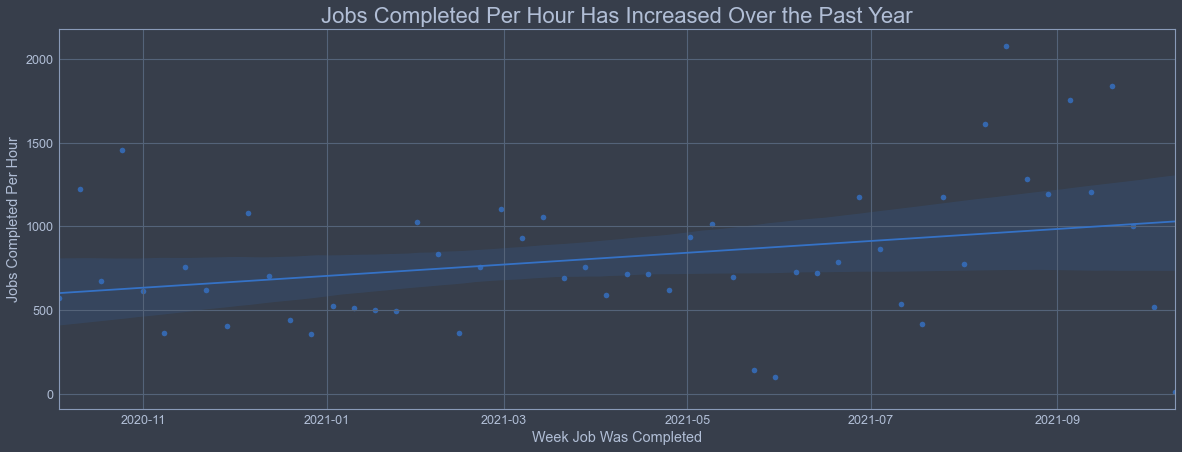

In [20]:
# Plot completions per hour by week along with trendline, which shows gradual increase over the year
fig, ax = plt.subplots(figsize=(20,7))

ax.xaxis.update_units(ended_per_hour_by_week['WEEKOF'])

sns.regplot(x = ax.xaxis.convert_units(ended_per_hour_by_week['WEEKOF']),
            y = 'ENDEDPERHOUR',
            data = ended_per_hour_by_week,
            ax = ax,
            #hue = x_dates,
            #dodge = False
           )

ax.set(xlabel = 'Week Job Was Completed',
       ylabel = 'Jobs Completed Per Hour'
      )
ax.set_title('Jobs Completed Per Hour Has Increased Over the Past Year',
      fontdict = {'fontsize' : 22}
      )
plt.show()

### Answer: statsmodel regression confirms that the increasing trend is significant and has a slope of 1.15 jobs per hour per day 
(units are in days even though summary values are by week)

In [21]:
jobs_ended_vs_week_model = (sm.GLM(endog = ended_per_hour_by_week['ENDEDPERHOUR'],
                      exog = sm.add_constant(ended_per_hour_by_week['WEEKOF'].map(datetime.toordinal)),
                      family = sm.families.Gaussian())
               .fit())

print(jobs_ended_vs_week_model.summary())
print('Linear AIC: '+str(jobs_ended_vs_week_model.aic))

                 Generalized Linear Model Regression Results                  
Dep. Variable:           ENDEDPERHOUR   No. Observations:                   54
Model:                            GLM   Df Residuals:                       52
Model Family:                Gaussian   Df Model:                            1
Link Function:               identity   Scale:                      1.6503e+05
Method:                          IRLS   Log-Likelihood:                -399.98
Date:                Sat, 06 Nov 2021   Deviance:                   8.5815e+06
Time:                        09:52:59   Pearson chi2:                 8.58e+06
No. Iterations:                     3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const      -8.499e+05   3.74e+05     -2.273      0.0

### jobs completed per hour by day, summarized by day of the week. 
### Answer: summary of weekday jobs per hour shows highest volume of completions early in the work week (Monday - Wednesay).

In [22]:
ended_per_hour_by_day = (slurm_jobs.groupby(
                                            pd.Grouper(key = 'END', freq = 'D') # Group END by day
                                           ) 
                                    ['JOBID'] # Counting job ids
                                    .count()/24 # divide count by 24 hours in a day
                        )

In [23]:
# display with renamed columns
ended_per_hour_by_day = (ended_per_hour_by_day.reset_index()
                                              .rename(columns = {'END': 'DAY', 
                                                                 'JOBID': 'ENDEDPERHOUR'}
                                                     )
                        )

In [24]:
# Add weekday and weekday number to completions per hour by day
ended_per_hour_by_day['WEEKDAY'] = ended_per_hour_by_day['DAY'].apply(lambda x: calendar.day_name[x.weekday()])
ended_per_hour_by_day['WEEKDAYNUMBER'] = ended_per_hour_by_day['DAY'].apply(lambda x: x.weekday()+1)
ended_per_hour_by_day

,DAY,ENDEDPERHOUR,WEEKDAY,WEEKDAYNUMBER
0,2020-10-01,1386.708333,Thursday,4
1,2020-10-02,1265.625000,Friday,5
2,2020-10-03,640.333333,Saturday,6
3,2020-10-04,732.541667,Sunday,7
4,2020-10-05,1006.916667,Monday,1
...,...,...,...,...
367,2021-10-03,81.416667,Sunday,7
368,2021-10-04,25.750000,Monday,1
369,2021-10-05,30.375000,Tuesday,2
370,2021-10-06,11.708333,Wednesday,3


In [25]:
# Aggregate by weekday
ended_per_hour_by_weekday = ended_per_hour_by_day.groupby(['WEEKDAYNUMBER', 'WEEKDAY'], as_index = False)['ENDEDPERHOUR'].mean()
ended_per_hour_by_weekday

,WEEKDAYNUMBER,WEEKDAY,ENDEDPERHOUR
0,1,Monday,881.209119
1,2,Tuesday,1022.036950
2,3,Wednesday,929.574686
3,4,Thursday,797.590278
4,5,Friday,807.621069
5,6,Saturday,666.738994
6,7,Sunday,694.043239


### Answer: bar plot shows same result, with Monday - Wednesday as only days above the overall average completions per hour (red line) calculated earlier. 
Weekend completions per hour look significantly low.

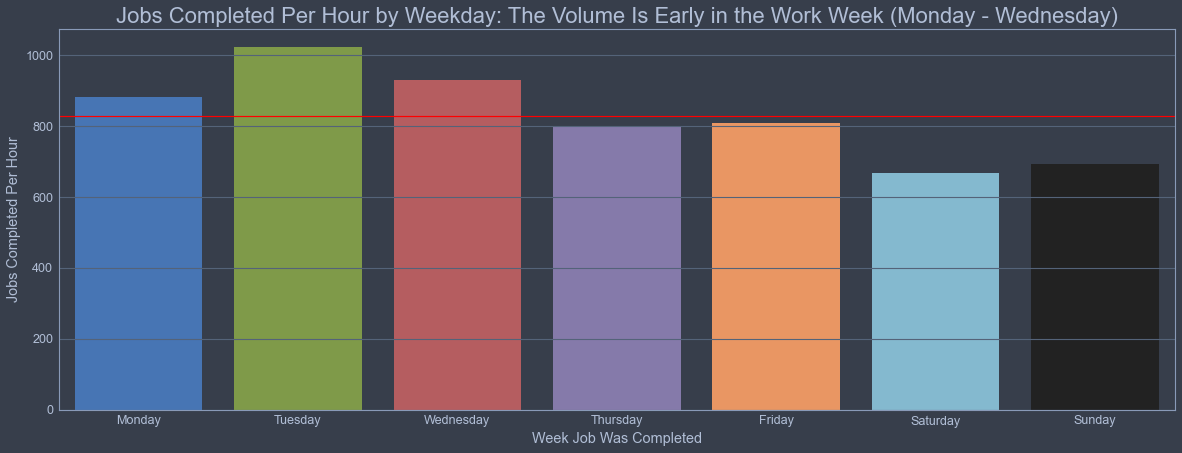

In [26]:
# Plot completions per hour by weekday
fig, ax = plt.subplots(figsize=(20,7))

sns.barplot(x = 'WEEKDAY',
            y = 'ENDEDPERHOUR',
            data = ended_per_hour_by_weekday,
            ax = ax,
           )

ax.axhline(jobs_per_hour, color = 'red')
ax.set(xlabel = 'Week Job Was Completed',
       ylabel = 'Jobs Completed Per Hour'
      )
ax.set_title('Jobs Completed Per Hour by Weekday: The Volume Is Early in the Work Week (Monday - Wednesday)',
            fontdict = {'fontsize' : 22}
            )
plt.show()

# Problem 2

(2A) Does the job state affect completions per hour? i.e. if I only look at jobs with exit code 0:0 in the "COMPLETED" state, is that a similar number of completions per hour as with all jobs, failed or cancelled? This will indicate if the load on the scheduler is by user design or is a result of users not sufficiently testing their jobs before submitting very large arrays. 

(2B) We also expect that most job completions will be in the "production" partition, but is this actually true?

## (2a) Does the job state affect completions per hour?

### Answer: Jobs ended per hour does vary by job state.

In particular, in an average hour, approximately

   * 53.72% COMPLETED
   * 27.93% FAILED
   * 9.24% TIMEOUT

### if a state is of the form "CANCELLED by ####" then replace with simply "CANCELLED by user": STATEMOD

In [27]:
slurm_jobs['STATEMOD'] = slurm_jobs['STATE'].str.replace(r'CANCELLED by \d+', 'CANCELLED by user', regex = True)
slurm_jobs['STATEMOD'].value_counts()

COMPLETED            5871385
FAILED               1095351
CANCELLED by user     228428
TIMEOUT               170748
PREEMPTED              24563
OUT_OF_MEMORY           4160
REQUEUED                 441
NODE_FAIL                127
RUNNING                   25
CANCELLED                  6
Name: STATEMOD, dtype: int64

In [28]:
slurm_by_state = (slurm_jobs
                            .groupby('STATEMOD', as_index = False)
                            .rolling('1h', on = 'END')
                            ['JOBID']
                            .count()
                            .reset_index()
                )

In [29]:
slurm_by_state_sum = (slurm_by_state
                 .groupby('STATEMOD', as_index = False)
                 ['JOBID']
                 .mean()
                 .rename(columns = {'JOBID': 'PERHOURMEAN'})
)

slurm_by_state_sum['PERHOURPROP'] = slurm_by_state_sum['PERHOURMEAN']/slurm_by_state_sum['PERHOURMEAN'].sum()
slurm_by_state_sum.sort_values('PERHOURMEAN', ascending = False)

,STATEMOD,PERHOURMEAN,PERHOURPROP
2,COMPLETED,2213.243912,0.537213
3,FAILED,1150.668905,0.279298
9,TIMEOUT,380.672886,0.092399
1,CANCELLED by user,215.944267,0.052415
7,REQUEUED,73.850340,0.017925
5,OUT_OF_MEMORY,45.312740,0.010999
6,PREEMPTED,23.145218,0.005618
8,RUNNING,11.160000,0.002709
4,NODE_FAIL,4.362205,0.001059
0,CANCELLED,1.500000,0.000364


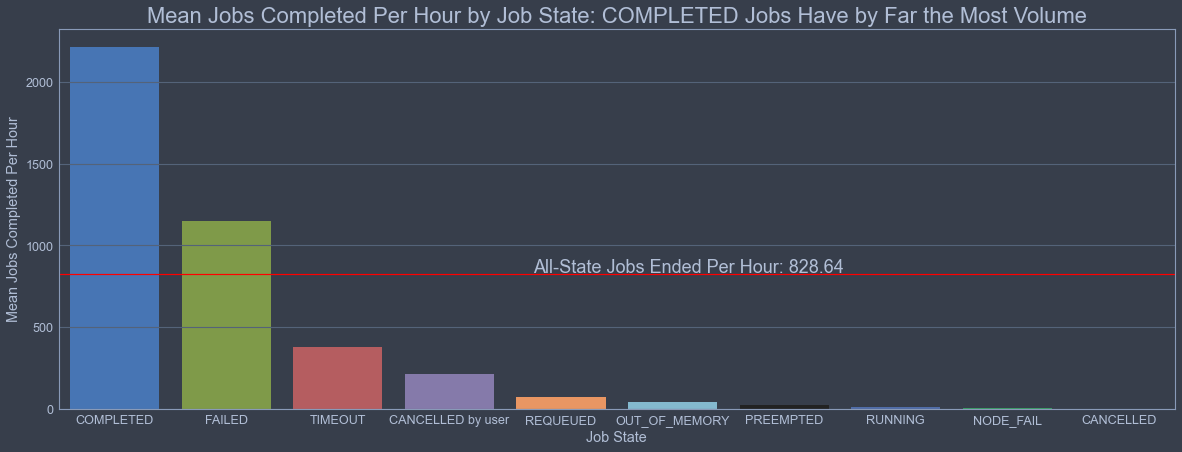

In [30]:
# Plot completions per hour by state
fig, ax = plt.subplots(figsize=(20,7))

sns.barplot(x = 'STATEMOD',
            y = 'PERHOURMEAN',
            data = slurm_by_state_sum,
            order = slurm_by_state_sum.sort_values('PERHOURMEAN', ascending = False)['STATEMOD'],
            ax = ax,
           )

ax.axhline(jobs_per_hour, color = 'red')
ax.annotate(text = f'All-State Jobs Ended Per Hour: {jobs_per_hour:.2f}', 
            xy = (3.75, jobs_per_hour+5),
            fontsize = 18)
ax.set(xlabel = 'Job State',
       ylabel = 'Mean Jobs Completed Per Hour')
ax.set_title('Mean Jobs Completed Per Hour by Job State: COMPLETED Jobs Have by Far the Most Volume',
            fontdict = {'fontsize' : 22}
            )
plt.show()

## (2B) We also expect that most job completions will be in the "production" partition, but is this actually true?

### Answer: Yes, most job completions (~95%) are in the "production" partition.

In [31]:
partitions_count = slurm_jobs['PARTITION'].value_counts().reset_index().rename(columns = {'index': 'PARTITION', 'PARTITION':'COUNT'})
partitions_prop = slurm_jobs['PARTITION'].value_counts(normalize = True).round(4).reset_index().rename(columns = {'index': 'PARTITION', 'PARTITION':'PROPORTION'})
partitions_count.merge(partitions_prop)

,PARTITION,COUNT,PROPORTION
0,production,7019136,0.9491
1,nogpfs,147044,0.0199
2,pascal,124451,0.0168
3,sam,64967,0.0088
4,turing,21412,0.0029
5,maxwell,11278,0.0015
6,cgw-maizie,4308,0.0006
7,debug,1616,0.0002
8,cgw-platypus,376,0.0001
9,cgw-dsi-gw,228,0.0000
